In [32]:
import os
import torch
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
import numpy as np
from einops import rearrange, pack

from pprint import pprint
from torch.utils.data import DataLoader

In [33]:
# from pathlib import Path
# import os

# root_dir = Path("/lfs/turing3/0/kaif/data/processed")
# mask_root_dir = root_dir / "masks"
# pre_root_dir = root_dir / "pre-scaled-fire-images"
# post_root_dir = root_dir / "post-fire-images"

# regions = [Path(f).stem for f in os.listdir(mask_root_dir)]

# files_mask = {f: mask_root_dir / f'{f}.npy' for f in regions}
# files_pre = {f: pre_root_dir / f'{f}.tif' for f in regions}
# files_post = {f: post_root_dir / f'{f}.tif' for f in regions}
# len(files_mask), len(files_pre), len(files_post), len(regions)

In [34]:
# IoUs = {}
# accs = {}

# from einops import pack, unpack
# from tqdm import tqdm

# bad_regions = {'CA4090112136820140731', 'CA3791712013219870831', 'CA3742412156820200816', 'CA3256911672719951128'}

# mean_list = []

# for region in tqdm(regions):
#     if region in bad_regions:
#         continue

#     ds_post = xr.open_dataset(files_post[region]).to_array().squeeze().transpose('y', 'x', 'band')
#     ds_pre = xr.open_dataset(files_pre[region]).to_array().squeeze().transpose('y', 'x', 'band')
    
#     ds_post = rescale_imshow_rgb(ds_post)
#     ds_pre = rescale_imshow_rgb(ds_pre)

#     mean_list.append(np.mean(ds_post, axis=(0, 1))) # Compute mean for each channel
#     mean_list.append(np.mean(ds_pre, axis=(0, 1))) # Compute mean for each channel

# mean_array = np.array(mean_list)
# print(mean_array.shape)
# overall_mean = np.mean(mean_array, axis=0)

# print(overall_mean)


# std_list = []

# for region in tqdm(regions):
#     if region in bad_regions:
#         continue

#     ds_post = xr.open_dataset(files_post[region]).to_array().squeeze().transpose('y', 'x', 'band')
#     ds_pre = xr.open_dataset(files_pre[region]).to_array().squeeze().transpose('y', 'x', 'band')
    
#     ds_post = rescale_imshow_rgb(ds_post)
#     ds_pre = rescale_imshow_rgb(ds_pre)

#     std_list.append(np.mean((ds_post.reshape(-1, ds_post.shape[-1]) - overall_mean) ** 2, axis=0))
#     std_list.append(np.mean((ds_pre.reshape(-1, ds_post.shape[-1]) - overall_mean) ** 2, axis=0))

# std_array = np.array(std_list)
# overall_std = np.sqrt(np.mean(std_array, axis=0))

# print(overall_std)

In [35]:
params = {
    'mean': [97.09689363, 97.28427036, 98.57064272, 116.35852306, 114.47721449, 3.76334845],
    'std': [64.17795164, 64.1141886, 65.90140603, 64.79696877, 66.58678831, 30.22436968]
}

In [36]:
ROBUST_PERCENTILE = 2.0

def rescale_imshow_rgb(darray, vmin=None, vmax=None, robust=True, axis=-1):
    assert robust or vmin is not None or vmax is not None

    ndim = len(darray.shape)
    if axis < 0:
        axis = ndim + axis

    reduce_dim = list(range(ndim))
    reduce_dim.remove(axis)

    # Calculate vmin and vmax automatically for `robust=True`
    # Assume that the last dimension of the array represents color channels
    # Make sure to apply np.nanpercentile over this dimension by specifying axis=-1
    if robust:
        if vmax is None:
            vmax = np.nanpercentile(darray, 100 - ROBUST_PERCENTILE, axis=reduce_dim, keepdims=True)
        if vmin is None:
            vmin = np.nanpercentile(darray, ROBUST_PERCENTILE, axis=reduce_dim, keepdims=True)
    # If not robust and one bound is None, calculate the default other bound
    # and check that an interval between them exists.
    elif vmax is None:
        vmax = 255 if np.issubdtype(darray.dtype, np.integer) else 1
        if np.any(vmax < vmin):
            raise ValueError(
                f"vmin={vmin!r} less than the default vmax ({vmax!r}) - you must supply "
                "a vmax > vmin in this case."
            )
    elif vmin is None:
        vmin = 0
        if np.any(vmin > vmax):
            raise ValueError(
                f"vmax={vmax!r} is less than the default vmin (0) - you must supply "
                "a vmin < vmax in this case."
            )
    # Compute a mask for where vmax equals vmin
    vmax_equals_vmin = np.isclose(vmax, vmin)

    # Avoid division by zero by replacing zero divisors with 1
    divisor = np.where(vmax_equals_vmin, vmax, vmax - vmin)

    # Scale interval [vmin .. vmax] to [0 .. 1], using darray as 64-bit float
    darray = ((darray.astype("f8") - vmin) / divisor).astype("f4")
    
    return np.nan_to_num(np.minimum(np.maximum(darray, 0), 1) * 255).astype(np.uint8)


In [37]:
from pathlib import Path
import os

import rasterio
import rioxarray
import xarray as xr

from torch.utils.data import Dataset

def load_image(file_path, channels=[2, 3, 4]):
    image = xr.open_dataset(file_path).to_array().squeeze().transpose('y', 'x', 'band')
    image = rescale_imshow_rgb(image)
    image = image[:, :, channels]
    return image

bad_regions = {'CA4090112136820140731', 'CA3791712013219870831', 'CA3742412156820200816', 'CA3256911672719951128'}

class ImageMaskDataset(Dataset):
    def __init__(self, directory = Path("/lfs/turing3/0/kaif/data/processed")):
        mask_root_dir = directory / "masks"
        pre_root_dir = directory / "pre-scaled-fire-images"
        post_root_dir = directory / "post-fire-images"
        
        self.regions = [Path(f).stem for f in os.listdir(mask_root_dir)]
        for r in bad_regions:
            self.regions.remove(r)
        
        self.files_mask = {f: mask_root_dir / f'{f}.npy' for f in self.regions}
        self.files_pre = {f: pre_root_dir / f'{f}.tif' for f in self.regions}
        self.files_post = {f: post_root_dir / f'{f}.tif' for f in self.regions}

    def __len__(self):
        return len(self.regions)

    def __getitem__(self, idx):
        region = self.regions[idx]

        pre_data = load_image(self.files_pre[region], channels=[0, 1, 2, 3, 4, 5])
        post_data = load_image(self.files_post[region], channels=[0, 1, 2, 3, 4, 5])
        mask = np.load(self.files_mask[region])

        return pre_data, post_data, mask

In [38]:
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as T
import torchvision.transforms.functional as F

def get_bounding_box(ground_truth_map):
    # get bounding box from mask
    y_indices, x_indices = np.where(ground_truth_map > 0)
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)
    # add perturbation to bounding box coordinates
    H, W = ground_truth_map.shape
    x_min = max(0, x_min - np.random.randint(0, 20))
    x_max = min(W, x_max + np.random.randint(0, 20))
    y_min = max(0, y_min - np.random.randint(0, 20))
    y_max = min(H, y_max + np.random.randint(0, 20))
    bbox = [x_min, y_min, x_max, y_max]
    
    return bbox

def resize_and_pad(img, output_size=(256,256), means=params['mean'], stds=params['std'], padding_mode='constant'):
    # Get initial dimensions
    c, h, w = img.shape

    # Normalise the image
    if means is not None and stds is not None:
        transform = T.Normalize(mean=means, std=stds)
        img = transform(img)

    # Calculate new dimension while maintaining the aspect ratio
    if h >= w:
        new_h, new_w = output_size[0], int(output_size[0] * w / h)
    else:
        new_h, new_w = int(output_size[1] * h / w), output_size[1]

    # Resize the image
    img = F.resize(img, (new_h, new_w))

    # This is padding, it requires padding_left, padding_right,
    # padding_top and padding_bottom respectively.
    pad_height = max(output_size[0] - img.shape[1], 0)
    pad_width = max(output_size[1] - img.shape[2], 0)

    # Center padding
    pad_height1 = pad_height // 2
    pad_height2 = pad_height - pad_height1
    pad_width1 = pad_width // 2
    pad_width2 = pad_width - pad_width1

    # Pad the image
    img = F.pad(img, (pad_width1, pad_height1, pad_width2, pad_height2), padding_mode=padding_mode)

    return img

class SAMDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        pre_data, post_data, mask = self.dataset[idx]
        image, _ = pack([post_data, pre_data], 'x y *')
        image = torch.tensor(image, dtype=torch.float)
        ground_truth_mask = torch.tensor(mask, dtype=torch.float)

        image = resize_and_pad(rearrange(image, 'x y c -> c x y'), means=params['mean']*2, stds=params['std']*2)
        mask = resize_and_pad(rearrange(ground_truth_mask, 'x y -> 1 x y'), means=None, stds=None)
        return {'image': image, 'mask': mask}

In [39]:
import torch

torch.set_num_threads(5)
torch.set_num_interop_threads(5)

In [40]:
from torch.utils.data import DataLoader
from torch.utils.data import random_split

dataset = ImageMaskDataset()
sam_dataset = SAMDataset(dataset=dataset)

In [41]:
from tqdm import tqdm
data = [d for d in tqdm(sam_dataset)]

100%|█████████████████████████████████████████████████| 1586/1586 [02:38<00:00, 10.00it/s]


In [42]:
def get_size(a):
    return a.element_size() * a.nelement()
(get_size(data[0]['image']) * len(data) + get_size(data[0]['mask']) * len(data)) / 1028 / 1028 / 1028

4.975160700465691

In [43]:
class PrecomputedDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx]

precomputed_dataset = PrecomputedDataset(data)

# Define the proportions for the train/val split
train_prop = int(0.8 * len(precomputed_dataset))  # 80% of the dataset
val_prop = len(precomputed_dataset) - train_prop  # 20% of the dataset

# Create the train and validation datasets
train_dataset, val_dataset = random_split(precomputed_dataset, [train_prop, val_prop], generator=torch.Generator().manual_seed(42))

train_dataloader = DataLoader(train_dataset, batch_size=32, num_workers=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, num_workers=8, shuffle=False)

In [44]:
class UNetModel(pl.LightningModule):

    def __init__(self, arch, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()
        self.save_hyperparameters()
        self.model = smp.create_model(
            arch, encoder_name=encoder_name, in_channels=in_channels, classes=out_classes, **kwargs
        )

        # preprocessing parameteres for image
        # params = smp.encoders.get_preprocessing_params(encoder_name)
        # self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        # self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        # for image segmentation dice loss could be the best first choice
        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

        self.training_step_outputs = []
        self.valid_step_outputs = []
        self.test_step_outputs = []

    def forward(self, image):
        # normalize image here
        # image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def shared_step(self, batch, outputs, stage):
        
        image = batch['image']

        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert image.ndim == 4

        # Check that image dimensions are divisible by 32, 
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of 
        # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have 
        # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
        # and we will get an error trying to concat these features
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask = batch['mask']

        # Shape of the mask should be [batch_size, num_classes, height, width]
        # for binary segmentation num_classes = 1
        assert mask.ndim == 4

        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        assert mask.max() <= 1.0 and mask.min() >= 0

        logits_mask = self.forward(image)
        
        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.loss_fn(logits_mask, mask)

        # Lets compute metrics for some threshold
        # first convert mask values to probabilities, then 
        # apply thresholding
        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        # We will compute IoU metric by two ways
        #   1. dataset-wise
        #   2. image-wise
        # but for now we just compute true positive, false positive, false negative and
        # true negative 'pixels' for each image and class
        # these values will be aggregated in the end of an epoch
        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode="binary")

        metrics = {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }
        outputs.append(metrics)
        return metrics

    def shared_epoch_end(self, outputs, stage):
        # aggregate step metics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        if stage in ["valid", "test"]:
            tensorboard = self.logger.experiment
            plt.hist(smp.metrics.iou_score(tp, fp, fn, tn).cpu().flatten())
            tensorboard.add_figure(stage, plt.gcf())

        # per image IoU means that we first calculate IoU score for each image 
        # and then compute mean over these scores
        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
        
        # dataset IoU means that we aggregate intersection and union over whole dataset
        # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
        # in this particular case will not be much, however for dataset 
        # with "empty" images (images without target class) a large gap could be observed. 
        # Empty images influence a lot on per_image_iou and much less on dataset_iou.
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
            f"{stage}_accuracy": smp.metrics.accuracy(tp, fp, fn, tn, reduction="micro"),
            f"{stage}_f1": smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro"),
            f"{stage}_balanced_accuracy": smp.metrics.balanced_accuracy(tp, fp, fn, tn, reduction="micro")
        }
        
        self.log_dict(metrics, prog_bar=True)
        
        outputs.clear()

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, self.training_step_outputs, "train")            

    def on_train_epoch_end(self):
        return self.shared_epoch_end(self.training_step_outputs, "train")

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, self.valid_step_outputs, "valid")

    def on_validation_epoch_end(self):
        return self.shared_epoch_end(self.valid_step_outputs, "valid")

    def test_step(self, batch, batch_idx):
        return self.shared_step(batch, self.test_step_outputs, "test")  

    def on_test_epoch_end(self):
        return self.shared_epoch_end(self.test_step_outputs, "test")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0001)

In [45]:
from lightning.pytorch.loggers import TensorBoardLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

def train_model(model_name, backbone, device_id):
    model = UNetModel(model_name, backbone, in_channels=12, out_classes=1)
  
    logger = TensorBoardLogger(save_dir='logs', name=f"{model_name}_{backbone}")

    early_stop_callback = EarlyStopping(
        monitor="valid_dataset_iou", 
        min_delta=0.00, 
        patience=5, 
        verbose=False, 
        mode="max"
    )

    trainer = pl.Trainer(
        accelerator='auto',
        devices=[device_id],
        max_epochs=20,
        logger=logger,
        callbacks=[early_stop_callback]
    )

    trainer.fit(
        model, 
        train_dataloaders=train_dataloader, 
        val_dataloaders=val_dataloader,
    )

In [15]:
import gc

gc.collect()
torch.cuda.empty_cache()

In [ ]:
device_ids = [3, 4, 5, 6, 7, 8]

models = ["Unetplusplus", "FPN", "DeepLabV3plus", "Unet"]
backbones = ["resnet18", "resnet34", "resnet50", "timm-gernet_m", "timm-gernet_l", "timm-efficientnet-b5"]

# manager = Manager()
# device_queue = manager.Queue()

# for device_id in device_ids:
#     device_queue.put(device_id)

# processes = []

gc.collect()
with torch.no_grad():
    torch.cuda.empty_cache()

i = 0
for model in models:
    for backbone in backbones:
        print('=========================================================')
        print(model, backbone)
        train_model(model, backbone, device_ids[i % len(device_ids)])
        i += 1
        
        gc.collect()
        with torch.no_grad():
            torch.cuda.empty_cache()

In [57]:
# ('unetplusplus', 'resnet50', in_channels=12, out_classes=1)
model = UNetModel.load_from_checkpoint("/lfs/turing3/0/kaif/GitHub/burned/logs/Unetplusplus_resnet50/version_2/checkpoints/epoch=19-step=1600.ckpt", arch='unetplusplus', encoder_name='resnet50', in_channels=12, out_classes=1)
model.eval();

In [110]:
iou_scores = []

# Assume precomputed_dataset is your dataset
for i in tqdm(range(len(precomputed_dataset))):
    precomputed_data = precomputed_dataset[i]

    # Get predictions
    logits_mask = model(precomputed_data['image'].unsqueeze(0).to(model.device)).cpu()
    prob_mask = logits_mask.sigmoid()
    pred_mask = (prob_mask > 0.5).float().squeeze()

    mask = precomputed_data['mask'].squeeze()

    # Compute IoU score
    intersection = (pred_mask * mask).sum()
    union = (pred_mask + mask).sum() - intersection

    iou = (intersection + 1e-6) / (union + 1e-6)  # We add 1e-6 to both numerator and denominator to avoid division by zero
    iou_scores.append(iou.item())

print('Mean IoU Score:', np.mean(iou_scores))

100%|█████████████████████████████████████████████████| 1586/1586 [00:27<00:00, 58.64it/s]

Mean IoU Score: 0.9369579522787097


In [128]:
np.argsort(iou_scores)[50:60]

array([1467, 1295, 1393, 1552,  537, 1150, 1314,  672,  389,  680])

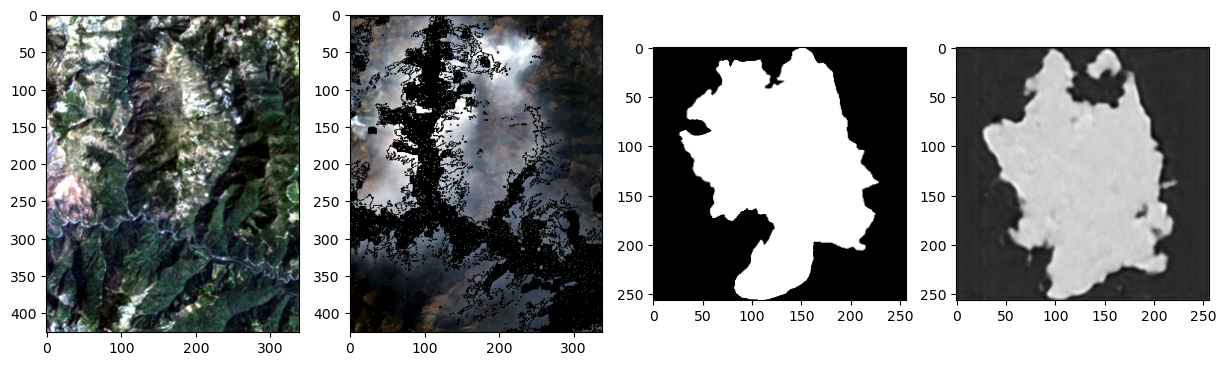

In [133]:
i = 1295

pre_data, post_data, mask = dataset[i]
precomputed_data = precomputed_dataset[i]

# plt.figure(figsize=(10,10))
fig, axs = plt.subplots(1, 4, figsize=(15, 7))

axs[0].imshow(pre_data[:, :, :3][:,:,::-1])
axs[1].imshow(post_data[:, :, :3][:,:,::-1])

# Mask
axs[2].imshow(precomputed_data['mask'].squeeze(), cmap='gray')

# pred
pred_mask = model(precomputed_data['image'].unsqueeze(0).to(model.device))
axs[3].imshow(pred_mask.detach().cpu().squeeze().numpy(), cmap='gray')

plt.show()

In [26]:
from lightning.pytorch.loggers import TensorBoardLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

model = UNetModel("FPN", "resnet34", in_channels=12, out_classes=1)

logger = TensorBoardLogger(save_dir='logs', name='FPN')

early_stop_callback = EarlyStopping(monitor="valid_dataset_iou", min_delta=0.00, patience=5, verbose=False, mode="max")

trainer = pl.Trainer(
    accelerator='auto',
    devices=[1],
    max_epochs=20,
    logger=logger,
    callbacks=[early_stop_callback]
)

trainer.fit(
    model, 
    train_dataloaders=train_dataloader, 
    val_dataloaders=val_dataloader,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]

  | Name    | Type     | Params
-------------------------------------
0 | model   | FPN      | 23.2 M
1 | loss_fn | DiceLoss | 0     
-------------------------------------
23.2 M    Trainable params
0         Non-trainable params
23.2 M    Total params
92.734    Total estimated model params size (MB)


Sanity Checking: |                                                  | 0/? [00:00<?, ?it/s]

/lfs/turing3/0/kaif/miniforge3/envs/burned/lib/python3.9/site-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (40) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                       | 0/? [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5f00d570d0>
Traceback (most recent call last):
  File "/lfs/turing3/0/kaif/miniforge3/envs/burned/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/lfs/turing3/0/kaif/miniforge3/envs/burned/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1474, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/lfs/turing3/0/kaif/miniforge3/envs/burned/lib/python3.9/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/lfs/turing3/0/kaif/miniforge3/envs/burned/lib/python3.9/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/lfs/turing3/0/kaif/miniforge3/envs/burned/lib/python3.9/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/lfs/turing3/0/kaif/miniforge3/envs/burned/lib/pyth

Validation: |                                                       | 0/? [00:00<?, ?it/s]

RuntimeError: DataLoader worker (pid(s) 43868, 43873, 43879, 43893, 43898, 43903, 43908, 43913) exited unexpectedly

In [27]:
import pandas as pd

data = {
    'Model': [
        ('DeepLabV3plus', 'resnet18'), ('DeepLabV3plus', 'resnet34'), 
        ('DeepLabV3plus', 'resnet50'), ('DeepLabV3plus', 'timm-efficientnet-b4'),
        ('DeepLabV3plus', 'timm-gernet_l'), ('DeepLabV3plus', 'timm-gernet_m'),
        ('FPN', 'resnet18'), ('FPN', 'resnet34'), ('FPN', 'resnet50'),
        ('FPN', 'timm-efficientnet-b4'), ('FPN', 'timm-gernet_l'), 
        ('FPN', 'timm-gernet_m'), ('Unet', 'resnet18'),
        ('Unet', 'resnet34'), ('Unet', 'resnet50'), ('Unet', 'timm-efficientnet-b4'),
        ('Unet', 'timm-gernet_l'), ('Unet', 'timm-gernet_m'), ('Unetplusplus', 'resnet18'),
        ('Unetplusplus', 'resnet34'), ('Unetplusplus', 'resnet50'), ('Unetplusplus', 'timm-efficientnet-b4'),
        ('Unetplusplus', 'timm-gernet_l'), ('Unetplusplus', 'timm-gernet_m')
    ],
    'Score': [
        0.8077, 0.8172, 0.8134, 0.8132, 0.7345, 0.7482, 0.8009, 0.8148,
        0.8091, 0.8135, 0.775, 0.7735, 0.7986, 0.8132, 0.8078, 0.8151, 
        0.7866, 0.7777, 0.8117, 0.8143, 0.8301, 0.7906, 0.8072, 0.8069
    ],
    'Epochs': [
        799, 799, 799, 1599, 799, 799, 799, 799, 799, 1599, 799, 799,
        799, 799, 799, 1599, 799, 799, 799, 799, 1599, 1599, 1279, 1599
    ],
    'Time': [
        '11/6/23, 11:36 PM', '11/6/23, 11:43 PM', '11/6/23, 11:51 PM', '11/7/23, 1:16 AM',
        '11/7/23, 12:26 AM', '11/7/23, 12:17 AM', '11/6/23, 11:36 PM', '11/6/23, 11:42 PM',
        '11/6/23, 11:49 PM', '11/7/23, 1:14 AM',  '11/7/23, 12:22 AM', '11/7/23, 12:16 AM',
        '11/6/23, 11:36 PM', '11/6/23, 11:43 PM', '11/6/23, 11:52 PM', '11/7/23, 1:14 AM',
        '11/7/23, 12:25 AM', '11/7/23, 12:17 AM', '11/6/23, 11:40 PM', '11/6/23, 11:51 PM',
        '11/7/23, 12:30 AM', '11/7/23, 1:17 AM', '11/7/23, 12:47 AM', '11/7/23, 12:39 AM'
    ],
    'Elapsed Time (min)': [
        6.189, 6.497, 7.797, 10.85, 8.211, 7.046, 6.31, 5.778, 6.765, 8.62,
        6.113, 5.912, 6.39, 6.6, 7.809, 9.33, 7.679, 7.242, 9.811, 10.53,
        16.26, 12.25, 7.269, 8.808
    ]
}

df = pd.DataFrame(data)
df[['Model', 'Backbone']] = pd.DataFrame(df.Model.tolist(), index= df.index)

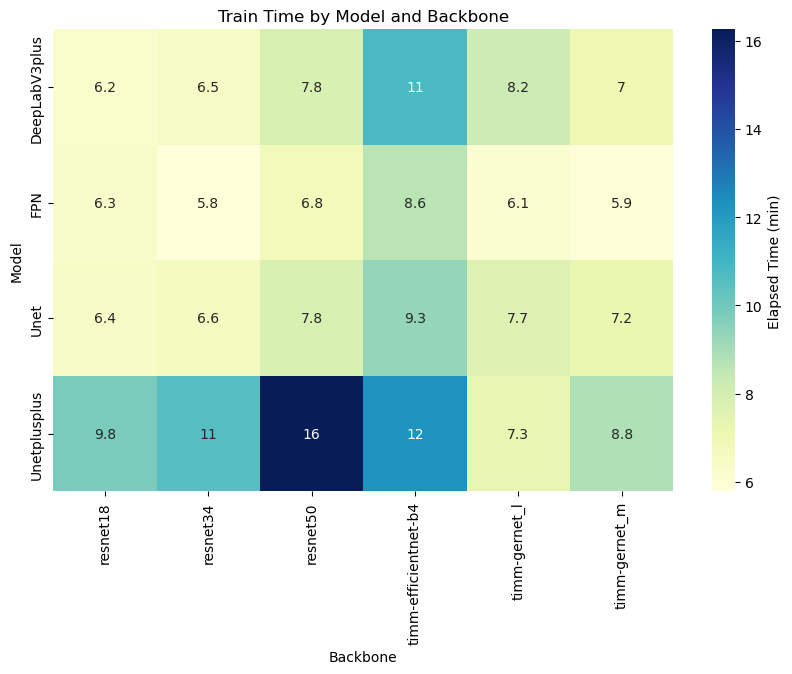

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# convert the tuples in the 'Model' column back to separate columns

pivot_table = df.pivot(index='Model', columns='Backbone', values='Elapsed Time (min)')
plt.figure(figsize=(10, 6))

sns.heatmap(pivot_table, cmap="YlGnBu", annot=True, cbar_kws={'label': 'Elapsed Time (min)'})
plt.title('Train Time by Model and Backbone')

plt.show()

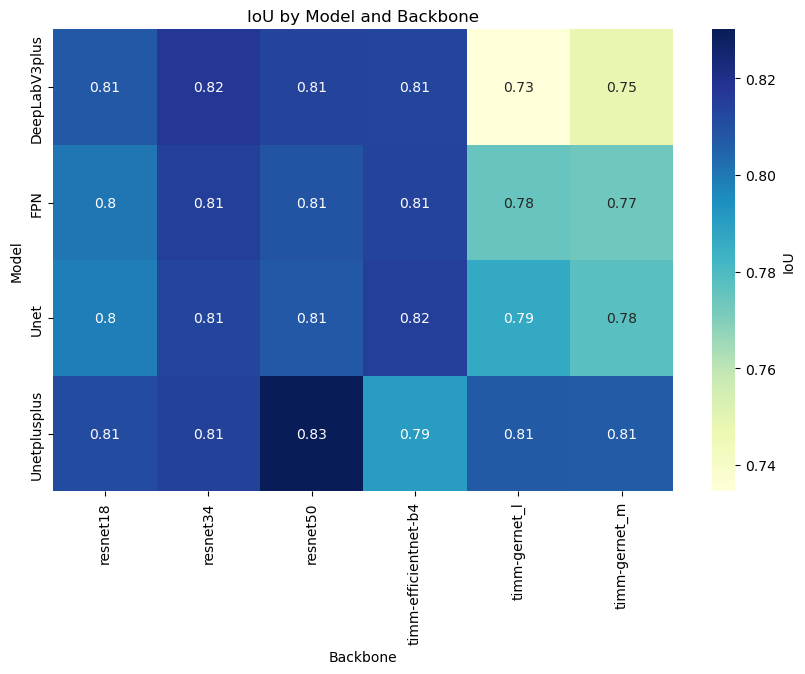

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# convert the tuples in the 'Model' column back to separate columns
df[['Model', 'Backbone']] = pd.DataFrame(df.Model.tolist(), index= df.index)

pivot_table = df.pivot(index='Model', columns='Backbone', values='Score')
plt.figure(figsize=(10, 6))

sns.heatmap(pivot_table, cmap="YlGnBu", annot=True, cbar_kws={'label': 'IoU'})
plt.title('IoU by Model and Backbone')

plt.show()

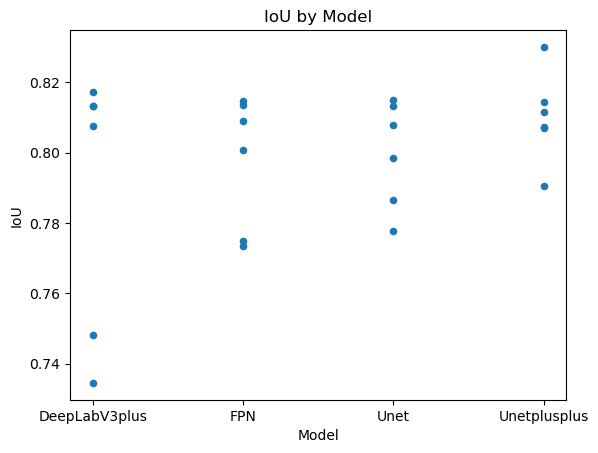

In [31]:
df.plot(x='Model', y='Score', kind='scatter')
plt.ylabel('IoU')
plt.title('IoU by Model')
plt.show()

Text(0.5, 1.0, 'IoU by Backbone')

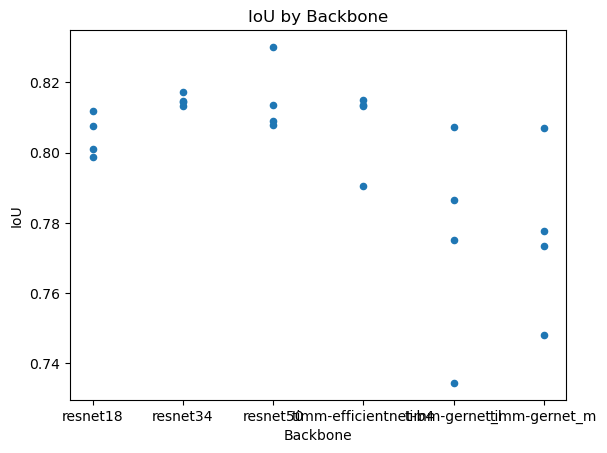

In [25]:
df.plot(x='Backbone', y='Score', kind='scatter')
plt.ylabel('IoU')
plt.title('IoU by Backbone')

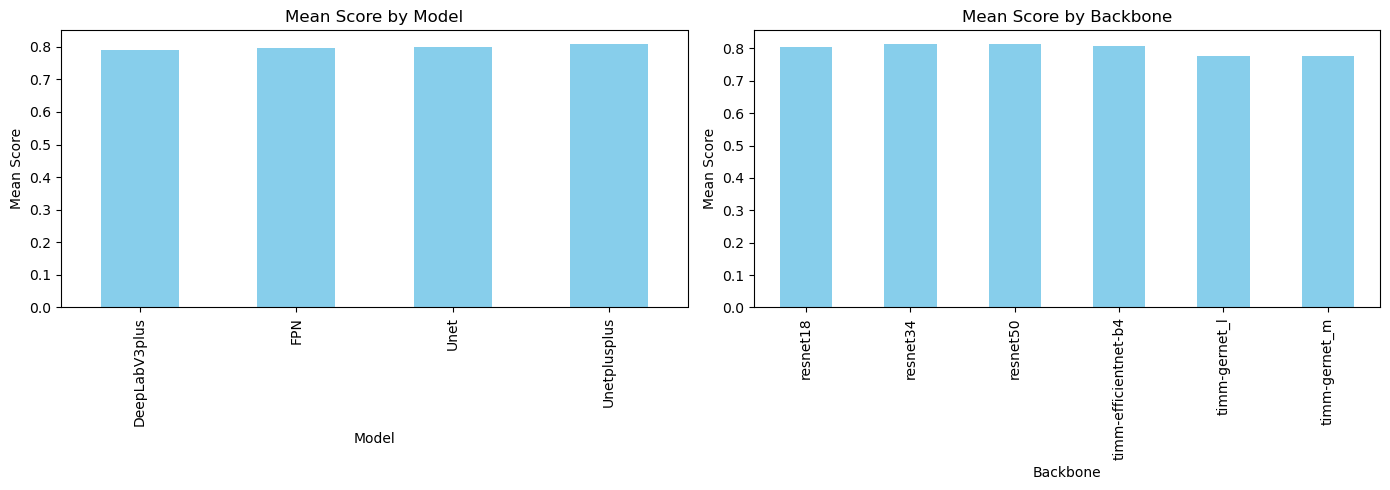

In [19]:
import matplotlib.pyplot as plt

# calculate mean scores per model and per backbone
mean_scores_model = df.groupby('Model')['Score'].mean()
mean_scores_backbone = df.groupby('Backbone')['Score'].mean()

plt.figure(figsize=(14, 5))

# plot for models
plt.subplot(1, 2, 1)
mean_scores_model.plot(kind='bar', color='skyblue')
plt.title('Mean Score by Model')
plt.ylabel('Mean Score')

# plot for backbones
plt.subplot(1, 2, 2)
mean_scores_backbone.plot(kind='bar', color='skyblue')
plt.title('Mean Score by Backbone')
plt.ylabel('Mean Score')

plt.tight_layout()
plt.show()

ValueError: plot kind scatter can only be used for data frames

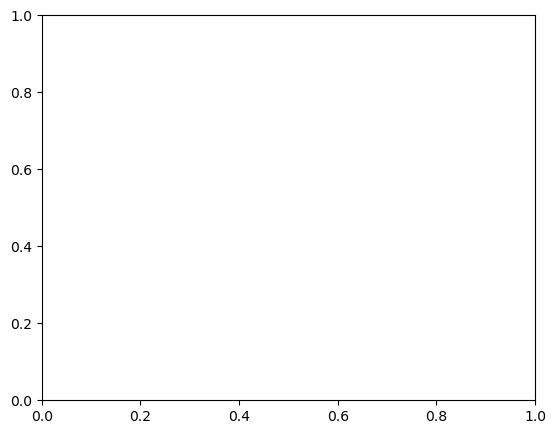

In [20]:
plt.figure(figsize=(14, 5))

# scatter plot for models
plt.subplot(1, 2, 1)
mean_scores_model.sort_values().plot(kind='scatter', x=mean_scores_model.index, y=mean_scores_model.values, color='blue')
plt.title('Mean Score by Model')
plt.xlabel('Model')
plt.ylabel('Mean Score')
plt.xticks(rotation=90)

# scatter plot for backbones
plt.subplot(1, 2, 2)
mean_scores_backbone.sort_values().plot(kind='scatter', x=mean_scores_backbone.index, y=mean_scores_backbone.values, color='blue')
plt.title('Mean Score by Backbone')
plt.xlabel('Backbone')
plt.ylabel('Mean Score')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()